In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from skimage.metrics import normalized_root_mse

In [2]:
dataset = pd.read_csv('Edited_Korea_Original.csv')
dataset

,Measurement date,Station code,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 00:00,102,0.006,0.068,0.002,1.3,77.0,63.0
2,2017-01-01 00:00,103,0.005,0.039,0.002,1.4,70.0,68.0
3,2017-01-01 00:00,104,0.005,0.045,0.003,0.6,73.0,46.0
4,2017-01-01 00:00,105,0.005,0.044,0.004,1.0,81.0,44.0
...,...,...,...,...,...,...,...,...
656995,2019-12-31 23:00,121,0.003,0.042,0.013,0.5,29.0,16.0
656996,2019-12-31 23:00,122,0.003,0.047,0.007,0.4,24.0,15.0
656997,2019-12-31 23:00,123,0.003,0.039,0.003,0.5,19.0,13.0
656998,2019-12-31 23:00,124,0.003,0.035,0.004,0.5,20.0,13.0


In [3]:
df = dataset[dataset['Station code'] == 101].iloc[:,2:]
df

,SO2,NO2,O3,CO,PM10,PM2.5
0,0.004,0.059,0.002,1.2,73.0,57.0
25,0.004,0.058,0.002,1.2,71.0,59.0
50,0.004,0.056,0.002,1.2,70.0,59.0
75,0.004,0.056,0.002,1.2,70.0,58.0
100,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...
656875,0.003,0.026,0.014,0.5,26.0,19.0
656900,0.003,0.024,0.014,0.4,27.0,19.0
656925,0.003,0.014,0.021,0.4,23.0,18.0
656950,0.003,0.022,0.014,0.5,20.0,19.0


In [4]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(df)
df1.shape

(26280, 6)

In [5]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [6]:
time_step = 100
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size - time_step:len(df1),:]
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
training_size, test_size

(18396, 7884)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((18295, 100, 6), (18295, 6), (7883, 100, 6), (7883, 6))

In [9]:
learning_rate = 0.01
model = Sequential()
model.add(LSTM(64, return_sequences = True, input_shape = (X_test.shape[1:])))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(64))
model.add(Dense(X_test.shape[2]))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mse", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 84,614
Trainable params: 84,614
Non-trainable params: 0
_________________________________________________________________


In [10]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 64,
    verbose = 1,
    callbacks = [es_callback, modelckpt_callback]
    )

Epoch 1/100
286/286 [==============================] - 39s 55ms/step - loss: 0.0076 - accuracy: 0.6126 - val_loss: 0.0027 - val_accuracy: 0.6955

Epoch 00001: val_loss improved from inf to 0.00269, saving model to model_checkpoint.h5
Epoch 2/100
286/286 [==============================] - 15s 52ms/step - loss: 0.0029 - accuracy: 0.7490 - val_loss: 0.0023 - val_accuracy: 0.7273

Epoch 00002: val_loss improved from 0.00269 to 0.00234, saving model to model_checkpoint.h5
Epoch 3/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0026 - accuracy: 0.7631 - val_loss: 0.0022 - val_accuracy: 0.7510

Epoch 00003: val_loss improved from 0.00234 to 0.00224, saving model to model_checkpoint.h5
Epoch 4/100
286/286 [==============================] - 14s 48ms/step - loss: 0.0025 - accuracy: 0.7795 - val_loss: 0.0021 - val_accuracy: 0.7658

Epoch 00004: val_loss improved from 0.00224 to 0.00205, saving model to model_checkpoint.h5
Epoch 5/100
286/286 [==============================]

In [11]:
model.save('the model')

INFO:tensorflow:Assets written to: the model\assets


INFO:tensorflow:Assets written to: the model\assets


In [12]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [13]:
features = df.columns.values
features

array(['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'], dtype=object)

In [14]:
print('Train values')
for i, feature in enumerate(features):
    obj = [j[i] for j in y_train]
    pred = [j[i] for j in train_predict]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print()

Train values
RMSE for SO2 is 0.045212064526771525
CV for SO2 is 0.8493232413724892

RMSE for NO2 is 0.05871391532842135
CV for NO2 is 0.8807223177864713

RMSE for O3 is 0.0515955849358779
CV for O3 is 0.8960974282886779

RMSE for CO is 0.04682798740950791
CV for CO is 0.8692877069399154

RMSE for PM10 is 0.037491341831720204
CV for PM10 is 0.9191405157563928

RMSE for PM2.5 is 0.02543467152294502
CV for PM2.5 is 0.925493259526908



In [15]:
print('Test values')
for i, feature in enumerate(features):
    obj = [j[i] for j in y_test]
    pred = [j[i] for j in test_predict]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print()

Test values
RMSE for SO2 is 0.04175677647062277
CV for SO2 is 0.6833626677531943

RMSE for NO2 is 0.05436958356779303
CV for NO2 is 0.8661453833972091

RMSE for O3 is 0.04933224899254303
CV for O3 is 0.881537202270717

RMSE for CO is 0.04188442290951678
CV for CO is 0.8565628698562135

RMSE for PM10 is 0.04798566992829102
CV for PM10 is 0.8586598068760074

RMSE for PM2.5 is 0.0380566141789744
CV for PM2.5 is 0.8260579717783365



In [16]:
qwe = scaler.inverse_transform(y_train)
qwe1 = scaler.inverse_transform(train_predict)
print('Train values')
for i, feature in enumerate(features):
    obj = [j[i] for j in qwe]
    pred = [j[i] for j in qwe1]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print()

Train values
RMSE for SO2 is 0.0006781809690111548
CV for SO2 is 0.8493232409504556

RMSE for NO2 is 0.005871391540311067
CV for NO2 is 0.8807223174727592

RMSE for O3 is 0.006191470192824332
CV for O3 is 0.8960974282714091

RMSE for CO is 0.09365597481901582
CV for CO is 0.8692877069399154

RMSE for PM10 is 7.460777031516524
CV for PM10 is 0.919140515681966

RMSE for PM2.5 is 4.858022274754007
CV for PM2.5 is 0.9254932590712266



In [17]:
qwe = scaler.inverse_transform(y_test)
qwe1 = scaler.inverse_transform(test_predict)
print('Test values')
for i, feature in enumerate(features):
    obj = [j[i] for j in qwe]
    pred = [j[i] for j in qwe1]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print()


Test values
RMSE for SO2 is 0.0006263516484417863
CV for SO2 is 0.683362667517827

RMSE for NO2 is 0.005436958346860603
CV for NO2 is 0.8661453838854125

RMSE for O3 is 0.005919869873412708
CV for O3 is 0.8815372025040191

RMSE for CO is 0.08376884581903356
CV for CO is 0.8565628698562135

RMSE for PM10 is 9.549148298469083
CV for PM10 is 0.8586598074379012

RMSE for PM2.5 is 7.268813276738327
CV for PM2.5 is 0.826057973394891



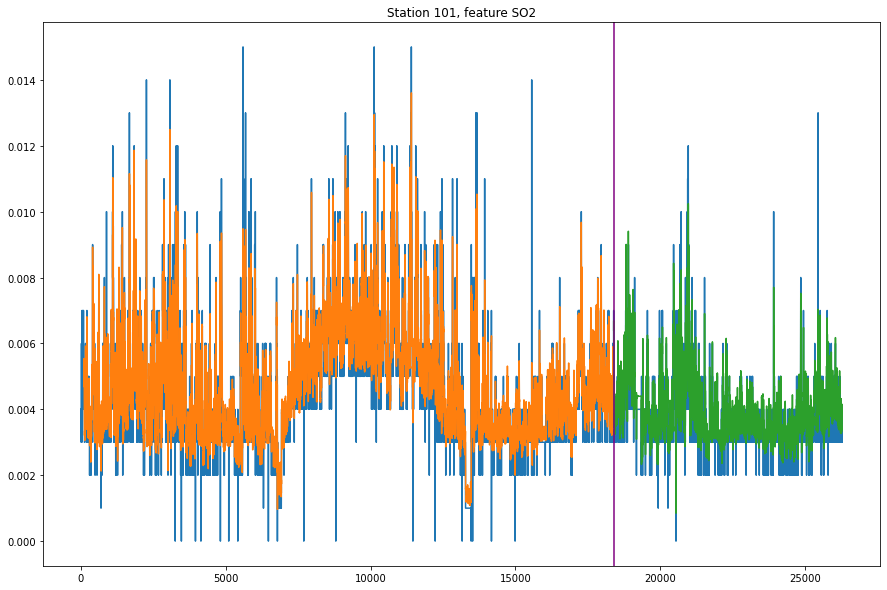

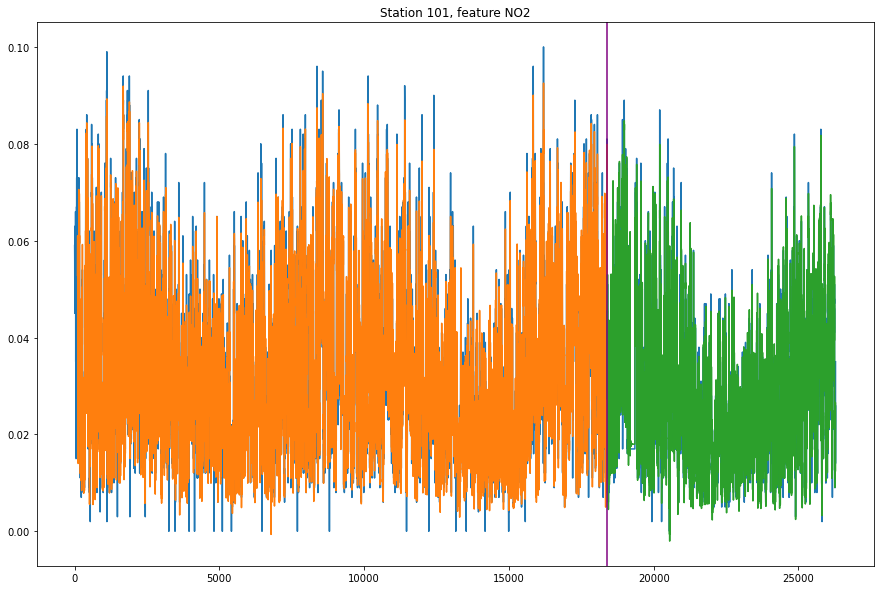

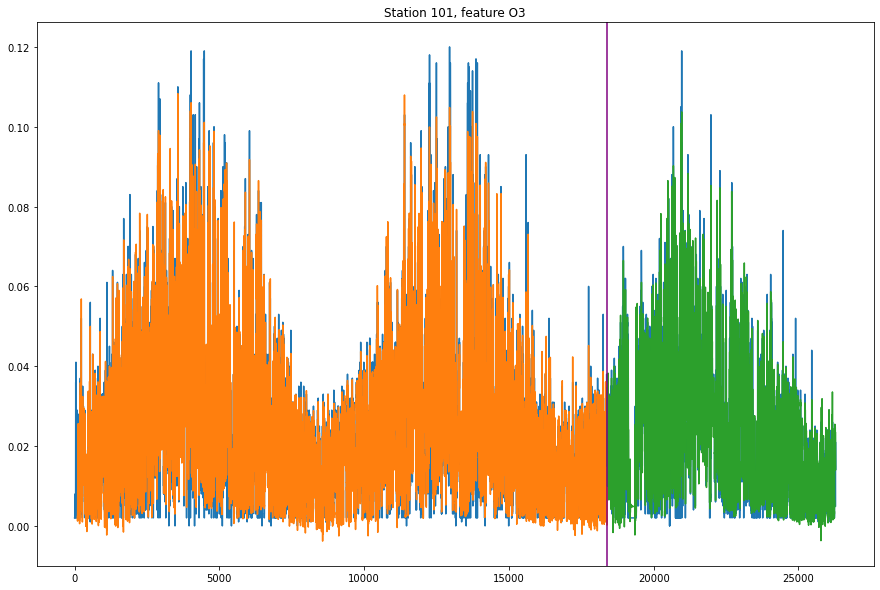

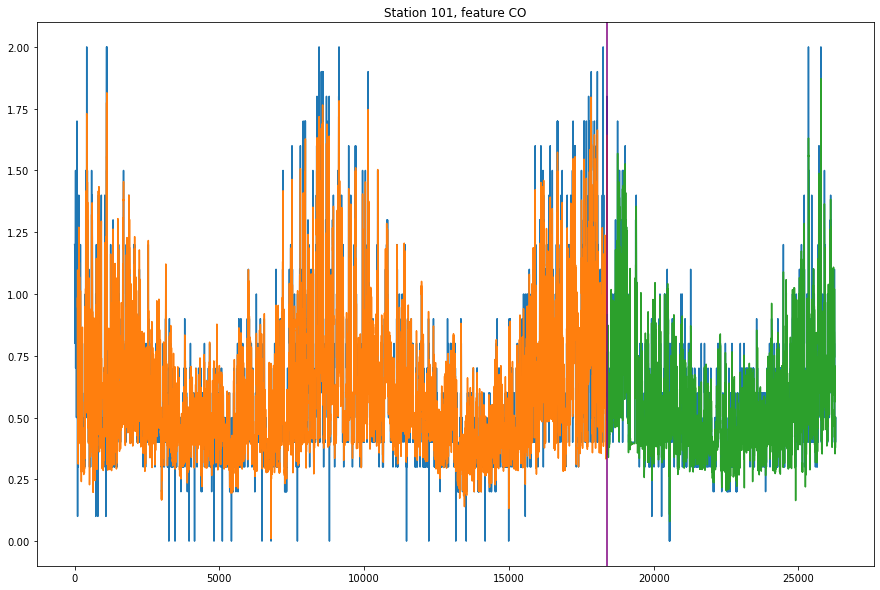

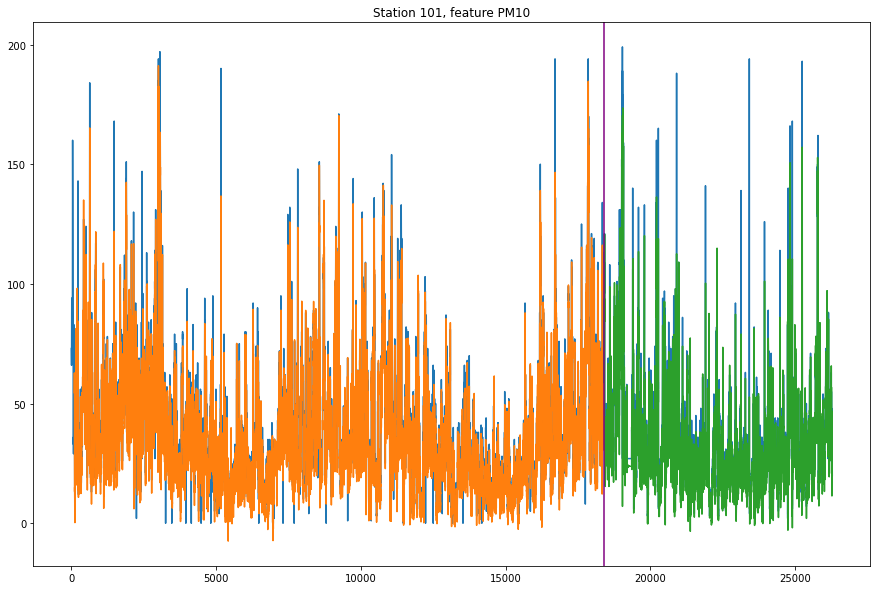

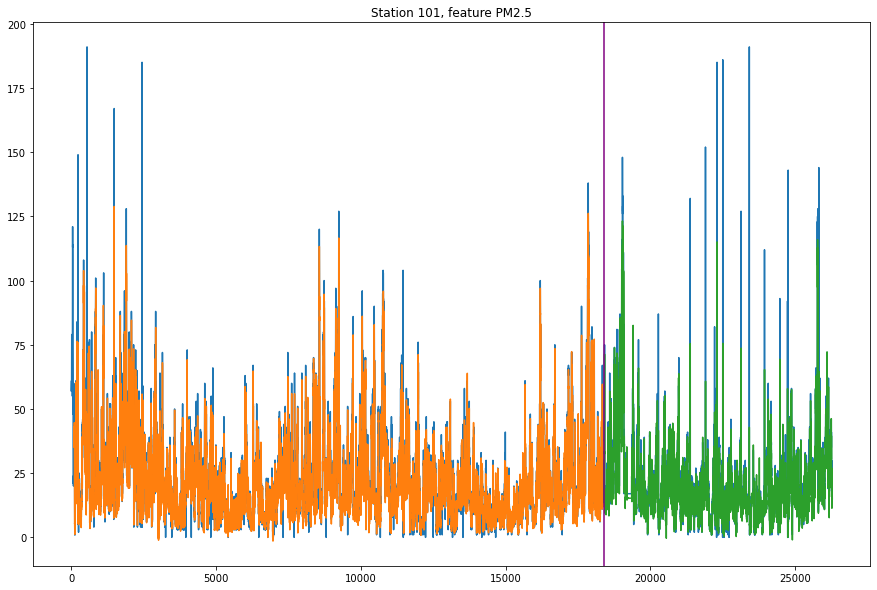

In [18]:

for indi, feature in enumerate(features):

    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
   
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    
    plt.plot(scaler.inverse_transform(df1)[:, indi])    
    plt.plot(trainPredictPlot[:, indi])
    plt.plot(testPredictPlot[:, indi])
    
    plt.axvline(x = len(train_predict) + time_step, color = 'purple')
    plt.title(f"Station 101, feature {feature}")
    plt.show()

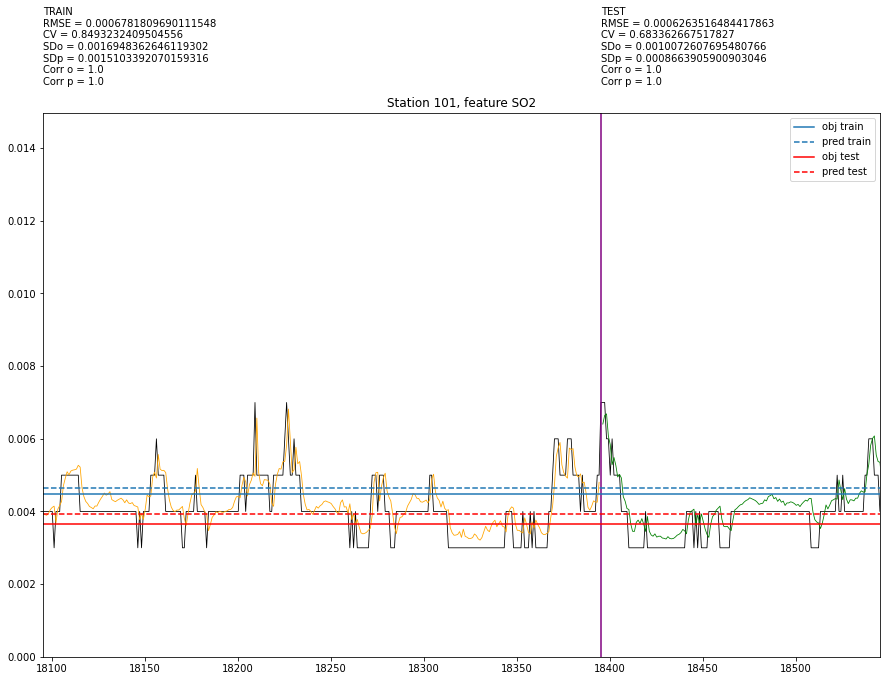

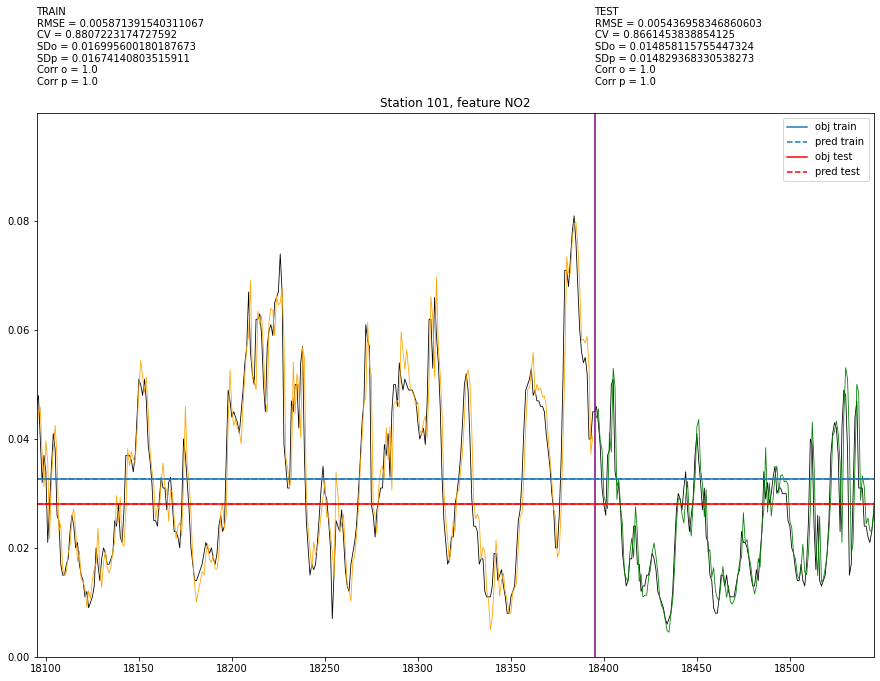

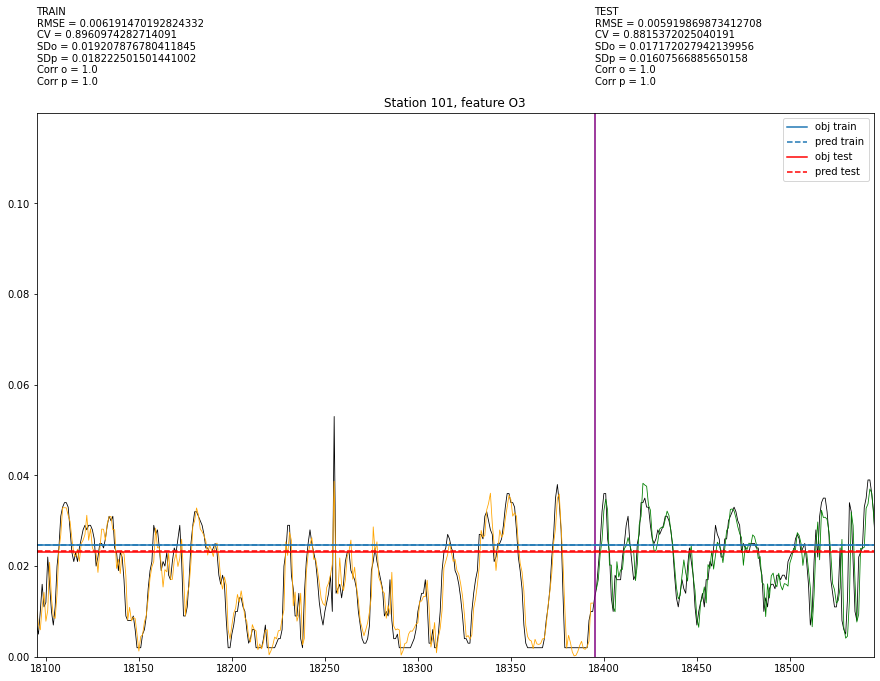

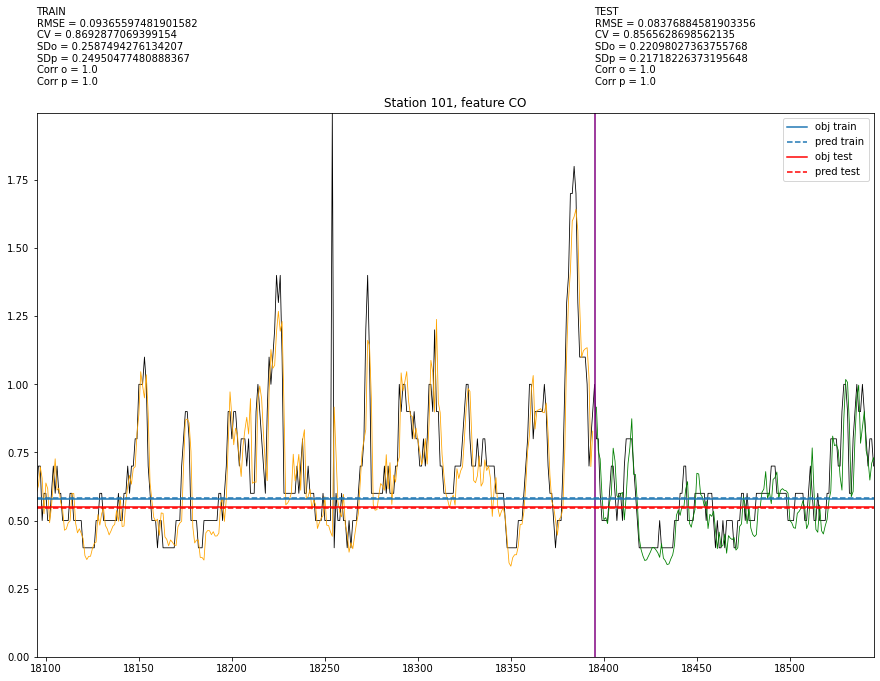

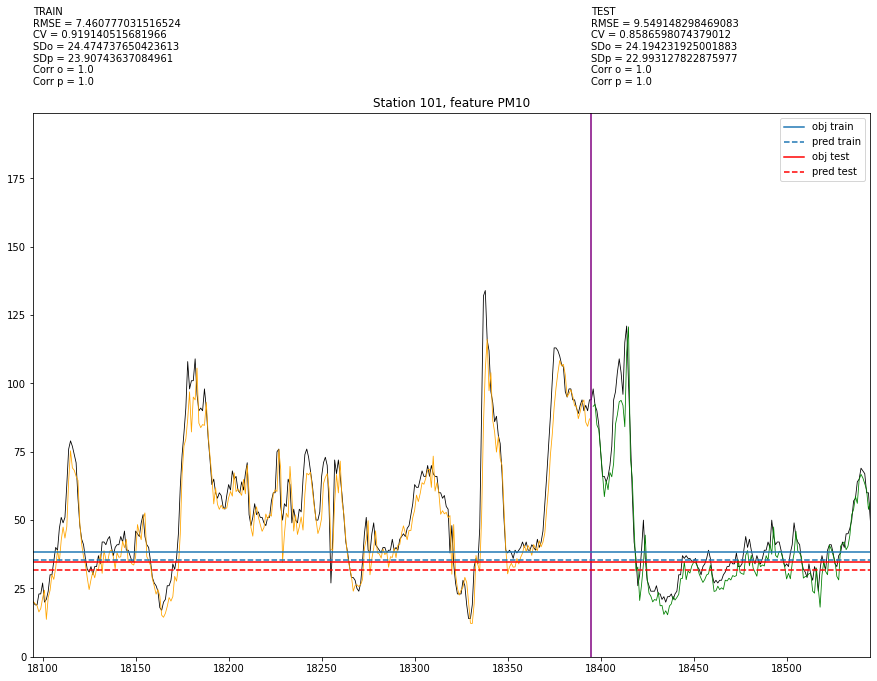

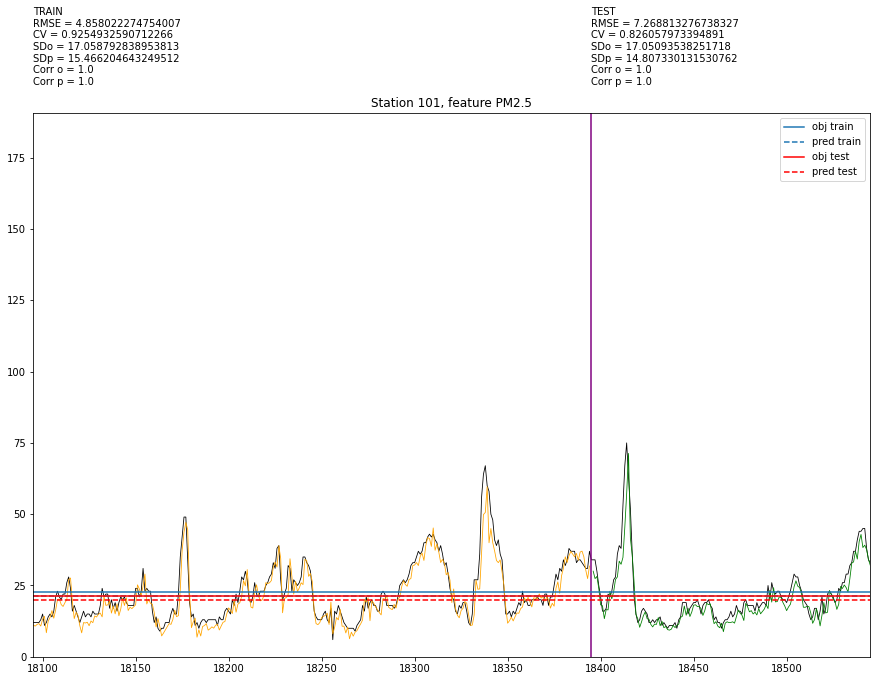

In [33]:
vbrk = 200
for indi, feature in enumerate(features):
 
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)

    plt.plot(scaler.inverse_transform(df1)[:, indi], color = 'black', linewidth = 0.8)
    plt.plot(trainPredictPlot[:, indi], color = 'orange', linewidth = 0.8)
    plt.plot(testPredictPlot[:, indi], color = 'green', linewidth = 0.8)

    xmin, xmax, ymin, ymax = plt.axis()
    plt.axis([len(train_predict) - vbrk, len(train_predict)+time_step/2 + vbrk, 0, ymax*0.95])

    plt.axvline(x=len(train_predict)+time_step, color = 'purple')
    plt.axhline(y = scaler.inverse_transform(y_train)[:,indi].mean(), label = 'obj train')
    plt.axhline(y = scaler.inverse_transform(train_predict)[:,indi].mean(), label = 'pred train', linestyle = 'dashed')
    plt.axhline(y = scaler.inverse_transform(y_test)[:,indi].mean(), label = 'obj test', color = 'red')
    plt.axhline(y = scaler.inverse_transform(test_predict)[:,indi].mean(), label = 'pred test', color = 'red', linestyle = 'dashed')
    

    obj = np.array([j[indi] for j in scaler.inverse_transform(y_train)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(train_predict)])    
    plt.text(len(train_predict) - vbrk, ymax, f'TRAIN\nRMSE = {mean_squared_error(obj, pred, squared=False)}\nCV = {explained_variance_score(obj, pred)}\nSDo = {obj.std()}\nSDp = {pred.std()}\nCorr o = {np.corrcoef(obj)}\nCorr p = {np.corrcoef(pred)}')


    obj = np.array([j[indi] for j in scaler.inverse_transform(y_test)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(test_predict)])  
    plt.text(len(train_predict) + time_step, ymax, f'TEST\nRMSE = {mean_squared_error(obj, pred, squared=False)}\nCV = {explained_variance_score(obj, pred)}\nSDo = {obj.std()}\nSDp = {pred.std()}\nCorr o = {np.corrcoef(obj)}\nCorr p = {np.corrcoef(pred)}')
    
    plt.title(f"Station 101, feature {feature}")
    plt.legend()
    plt.show()

In [32]:
print(np.corrcoef(y_train)) 
print(np.corrcoef(train_predict)) 
print(np.corrcoef(y_test)) 
print(np.corrcoef(test_predict)) 

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[1.         0.98711624 0.54348156 ... 0.81418781 0.83626725 0.88884627]
 [0.98711624 1.         0.56980558 ... 0.79978489 0.84607201 0.88631464]
 [0.54348156 0.56980558 1.         ... 0.58042906 0.52637954 0.52132619]
 ...
 [0.81418781 0.79978489 0.58042906 ... 1.         0.9784578  0.97851147]
 [0.83626725 0.84607201 0.52637954 ... 0.9784578  1.         0.99222266]
 [0.88884627 0.88631464 0.52132619 ... 0.97851147 0.99222266 1.        ]]
[[1.         0.99708653 0.99845394 ... 0.93606426 0.78248174 0.84282282]
 [0.99708653 1.         0.99817551 ... 0.95148804 0.79968484 0.85575128]
 [0.99845394 0.99817551 1.         ... 0.94696103 0.80539792 0.86258111]
 ...
 [0.93606426 0.95148804 0.94696103 ... 1.         0.93006133 0.95904447]
 [0.78248174 0.79968484 0.80539792 ... 0.93006133 1.         0.99034347]
 [0.84282282 0.85575128 0.86258111 ... 0.95904447 0.99034347 1.        ]]
[[1.         0.99353406 0.94039175 ... 0.71616972 0.17367915 0.51112173]
 [0.99353406 1.         0.94400585 ... 

In [65]:
from pprint import pprint
time_predict = 1000
lst_output=[]

x_input = test_data[len(test_data) - 100:]
temp_input = [x_input.tolist()]


for _ in range(time_predict):
    x_input = np.array(temp_input)
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    #pprint(temp_input)
    temp_input[0].extend(yhat.tolist())
    #print(temp_input)
    temp_input = [temp_input[0][1:]]
    #print('##########################')
    #pprint(temp_input)
    lst_output.extend(yhat.tolist())
    #break


Предикт для 1000 часов или 41 дней и 16 часов


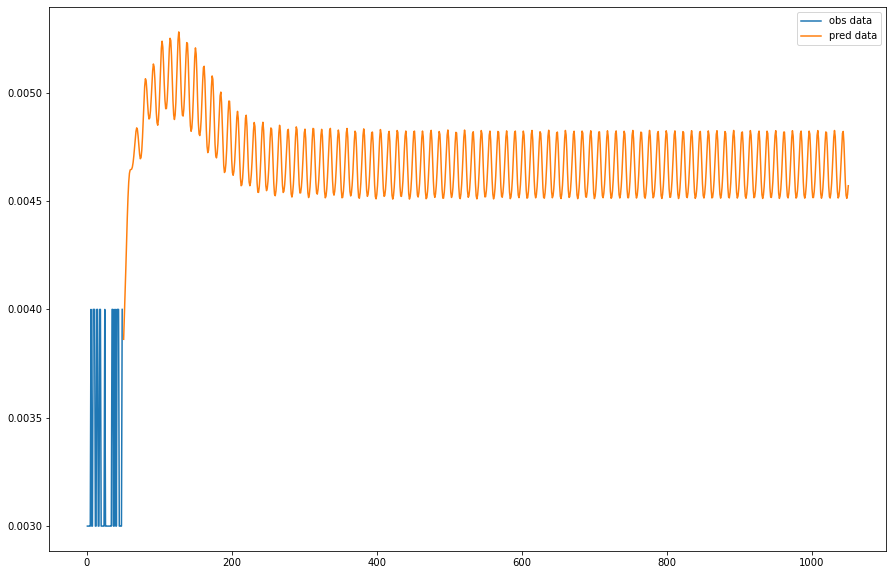

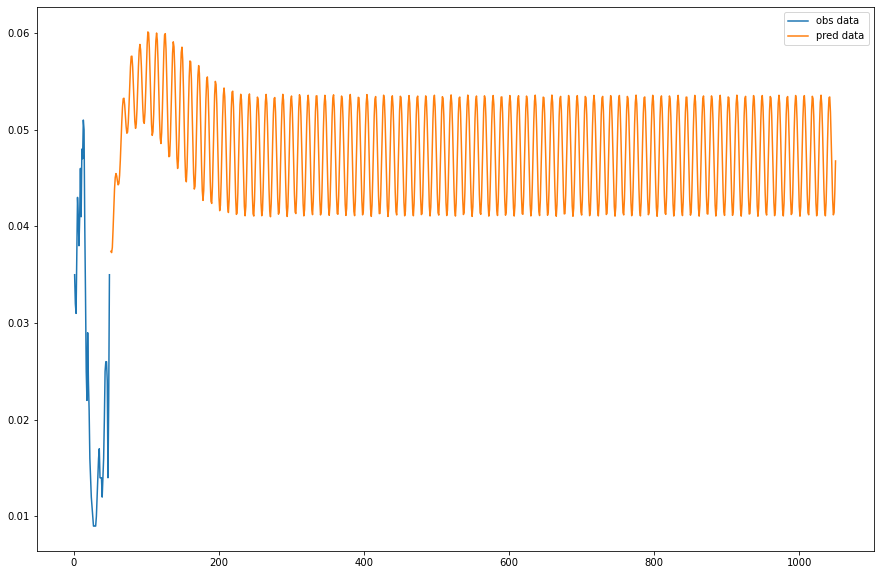

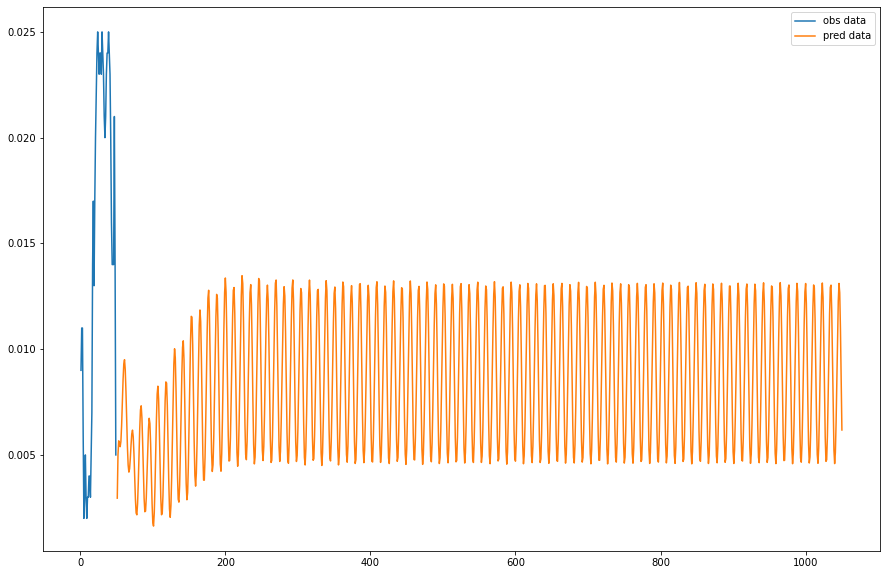

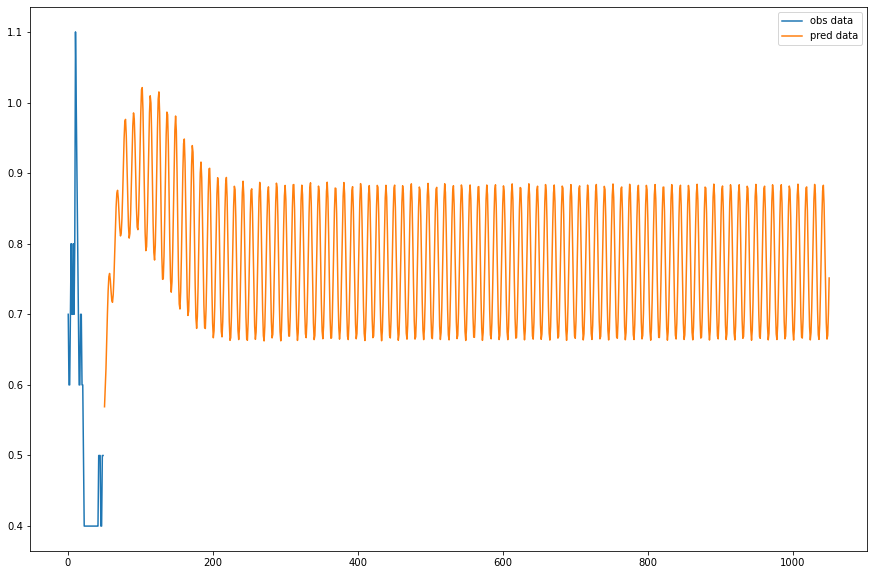

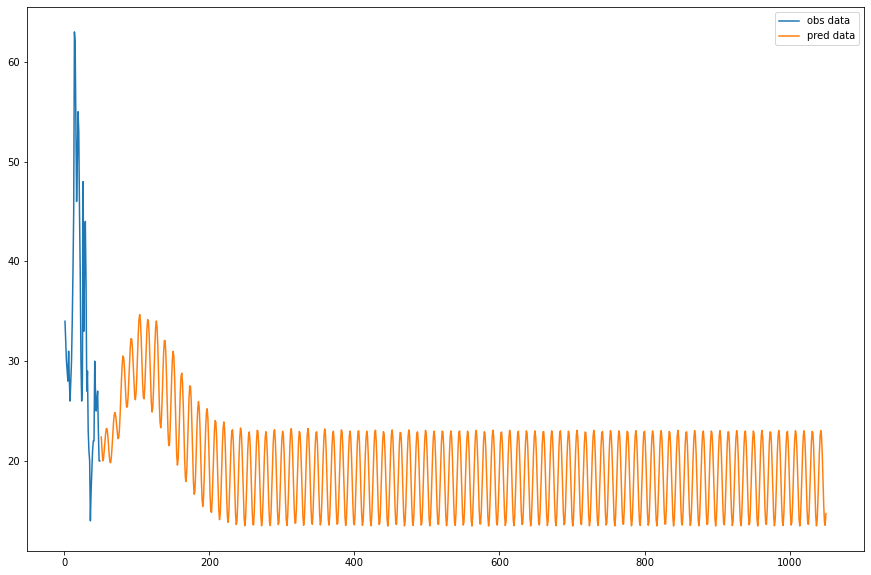

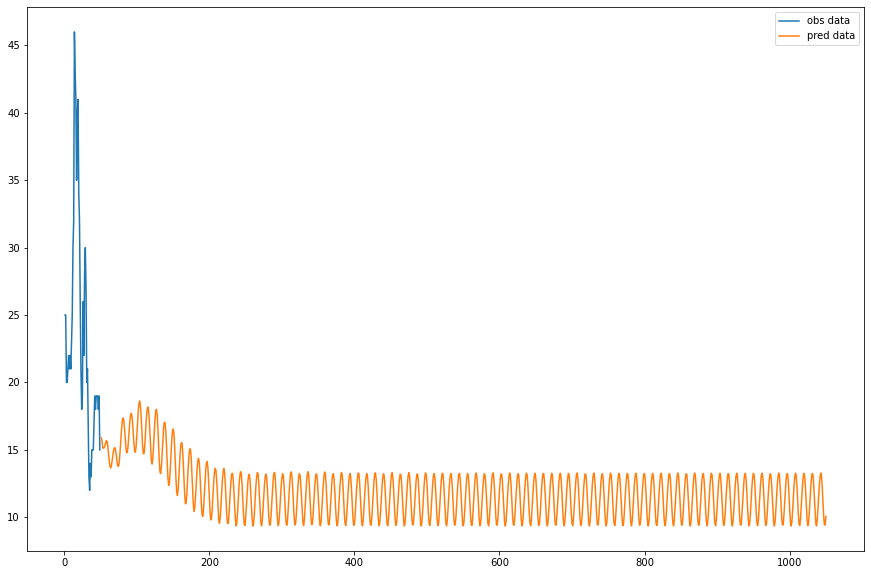

In [67]:
day_new=np.arange(1, 50)
day_pred=np.arange(51, 51 + time_predict)
print(f"Предикт для {time_predict} часов или {int(time_predict/24)} дней и {time_predict - 24*int(time_predict/24)} часов")
for j in range(6):
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(day_new, scaler.inverse_transform(df1)[len(df1) - 49:,j], label = 'obs data')
    plt.plot(day_pred, [i[j] for i in scaler.inverse_transform(lst_output)], label = 'pred data')
    plt.legend()
    plt.show()

In [26]:
# Менять колво входных точек на входе уменьша со 100 до 10 
# График зависимости рмсе от длины входного вектора (зачем?)
# Когда-нибудь потом через таблицу найти фичу
# Коэффициент корреляции